In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [18]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select distinct geometry, lp.cable_id, cmlcc.merge_length as cable_length from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [19]:
cable_coor[cable_coor['cable_length'].isna() == True]

,geometry,cable_id,cable_length


In [20]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_56322/4114155073.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,cable_id,cable_length,lon2,lat2
0,-74.205293,11.241938,colombian-festoon,400.0,NaN,NaN
1,-74.362373,11.331481,colombian-festoon,400.0,-74.205293,11.241938
2,-74.474873,11.221153,colombian-festoon,400.0,-74.362373,11.331481
3,-74.611933,11.012161,colombian-festoon,400.0,-74.474873,11.221153
4,-74.952802,11.005163,colombian-festoon,400.0,NaN,NaN
...,...,...,...,...,...,...
11078,-53.549888,-35.226267,tannat,2000.0,-50.849890,-34.487754
11079,-54.950187,-34.900416,tannat,2000.0,-53.549888,-35.226267
11080,-53.549888,-35.226267,tannat,2000.0,NaN,NaN
11081,-53.999888,-35.593029,tannat,2000.0,-53.549888,-35.226267


In [5]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [6]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

'sweden-finland-4-sfs-4'

In [21]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [22]:
gdf[gdf['cable_length'].isna()==True]

,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous


,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous
2,-74.474873,11.221153,colombian-festoon,400.0,-74.362373,11.331481,POINT (-74.47487 11.22115),POINT (-74.36237 11.33148),-6325372.0,-6303089.0,0.157571,2.729862,23.088449
3,-74.611933,11.012161,colombian-festoon,400.0,-74.474873,11.221153,POINT (-74.61193 11.01216),POINT (-74.47487 11.22115),-6359977.0,-6325372.0,0.249926,2.729862,36.621058
5,-75.149873,11.073983,colombian-festoon,400.0,-74.952802,11.005163,POINT (-75.14987 11.07398),POINT (-74.95280 11.00516),-6407589.0,-6394764.0,0.208741,2.729862,30.586299
6,-75.262372,10.963557,colombian-festoon,400.0,-75.149873,11.073983,POINT (-75.26237 10.96356),POINT (-75.14987 11.07398),-6429881.0,-6407589.0,0.157639,2.729862,23.098482
7,-75.505732,10.386791,colombian-festoon,400.0,-75.262372,10.963557,POINT (-75.50573 10.38679),POINT (-75.26237 10.96356),-6511894.0,-6429881.0,0.626005,2.729862,91.726940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,-50.849890,-34.487754,tannat,2000.0,-47.699892,-32.612760,POINT (-50.84989 -34.48775),POINT (-47.69989 -32.61276),-8533764.0,-8031265.0,3.665800,20.595168,355.986418
11078,-53.549888,-35.226267,tannat,2000.0,-50.849890,-34.487754,POINT (-53.54989 -35.22627),POINT (-50.84989 -34.48775),-8877616.0,-8533764.0,2.799177,20.595168,271.828483
11079,-54.950187,-34.900416,tannat,2000.0,-53.549888,-35.226267,POINT (-54.95019 -34.90042),POINT (-53.54989 -35.22627),-8985061.0,-8877616.0,1.437712,20.595168,139.616443
11081,-53.999888,-35.593029,tannat,2000.0,-53.549888,-35.226267,POINT (-53.99989 -35.59303),POINT (-53.54989 -35.22627),-8959292.0,-8877616.0,0.580529,20.595168,56.375281


In [23]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [159]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/cable_distance.csv")

<AxesSubplot:>

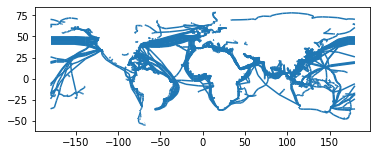

In [24]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot()

In [25]:
gdf = gdf.reset_index( )


In [26]:
gdf.sample(5)

,index,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,line,geometry
2723,3155,35.550049,42.412355,caucasus-cable-system,1200.0,41.400045,42.079236,POINT (35.55005 42.41235),POINT (41.40004 42.07924),7796240.0,8347928.0,5.859473,13.603429,516.881957,LINESTRING (35.55004905195153 42.4123545007357...,"LINESTRING (35.55005 42.41235, 41.40004 42.07924)"
2306,2673,64.350029,20.375041,peace-cable,15000.0,65.250028,22.884654,POINT (64.35003 20.37504),POINT (65.25003 22.88465),8472507.0,8813468.0,2.666112,145.917929,274.069726,LINESTRING (64.35002864977574 20.3750412534655...,"LINESTRING (64.35003 20.37504, 65.25003 22.88465)"
8563,9794,-42.299896,-23.803113,south-american-crossing-sac,20000.0,-43.209565,-22.903487,POINT (-42.29990 -23.80311),POINT (-43.20957 -22.90349),-6610301.0,-6611306.0,1.279385,169.046906,151.364512,LINESTRING (-42.299895798417 -23.8031131223491...,"LINESTRING (-42.29990 -23.80311, -43.20957 -22..."
7637,8736,127.912484,-8.011422,palapa-ring-east,6300.0,127.787884,-8.150378,POINT (127.91248 -8.01142),POINT (127.78788 -8.15038),11990106.0,11963750.0,0.186639,36.843430,31.914061,LINESTRING (127.91248362153638 -8.011421874117...,"LINESTRING (127.91248 -8.01142, 127.78788 -8.1..."
7704,8808,126.857214,19.479734,asia-submarine-cable-express-asecahaya-malaysia,8148.0,130.949981,23.917101,POINT (126.85721 19.47973),POINT (130.94998 23.91710),14633694.0,15486708.0,6.036635,72.471341,678.702844,LINESTRING (126.85721436909918 19.479734448240...,"LINESTRING (126.85721 19.47973, 130.94998 23.9..."


In [27]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous'], create_using=nx.Graph)


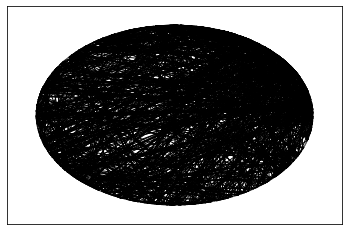

In [28]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [29]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [39]:
# path1 = nx.shortest_path(G,6181995, 10373031, weight = 'length')
# path2 = nx.shortest_path(G,2943486, 10373031, weight = 'length')


# set(path1).difference(set(path2))

In [30]:
path

[6181995,
 6137589.0,
 6124767.0,
 6186725.0,
 6191568.0,
 6178972.0,
 6163015.0,
 6176679.0,
 6151949.0,
 6131448.0,
 6088376.0,
 6057405.0,
 6054424.0,
 6077320.0,
 5995276.0,
 5805964.0,
 5564679.0,
 5291555.0,
 4983977.0,
 4838635.0,
 4773860.0,
 4782323.0,
 4816573.0,
 4915742.0,
 4859145.0,
 4847135.0,
 4712280.0,
 4352280.0,
 4001793.0,
 3380905.0,
 3146805.0,
 3029752.0,
 2957695.0,
 2705905.0,
 2652200.0,
 2669559.0,
 2619840.0,
 3055160.0,
 3925431.0,
 4193737.0,
 4423629.0,
 4628380.0,
 4618691.0,
 4629267]

<AxesSubplot:>

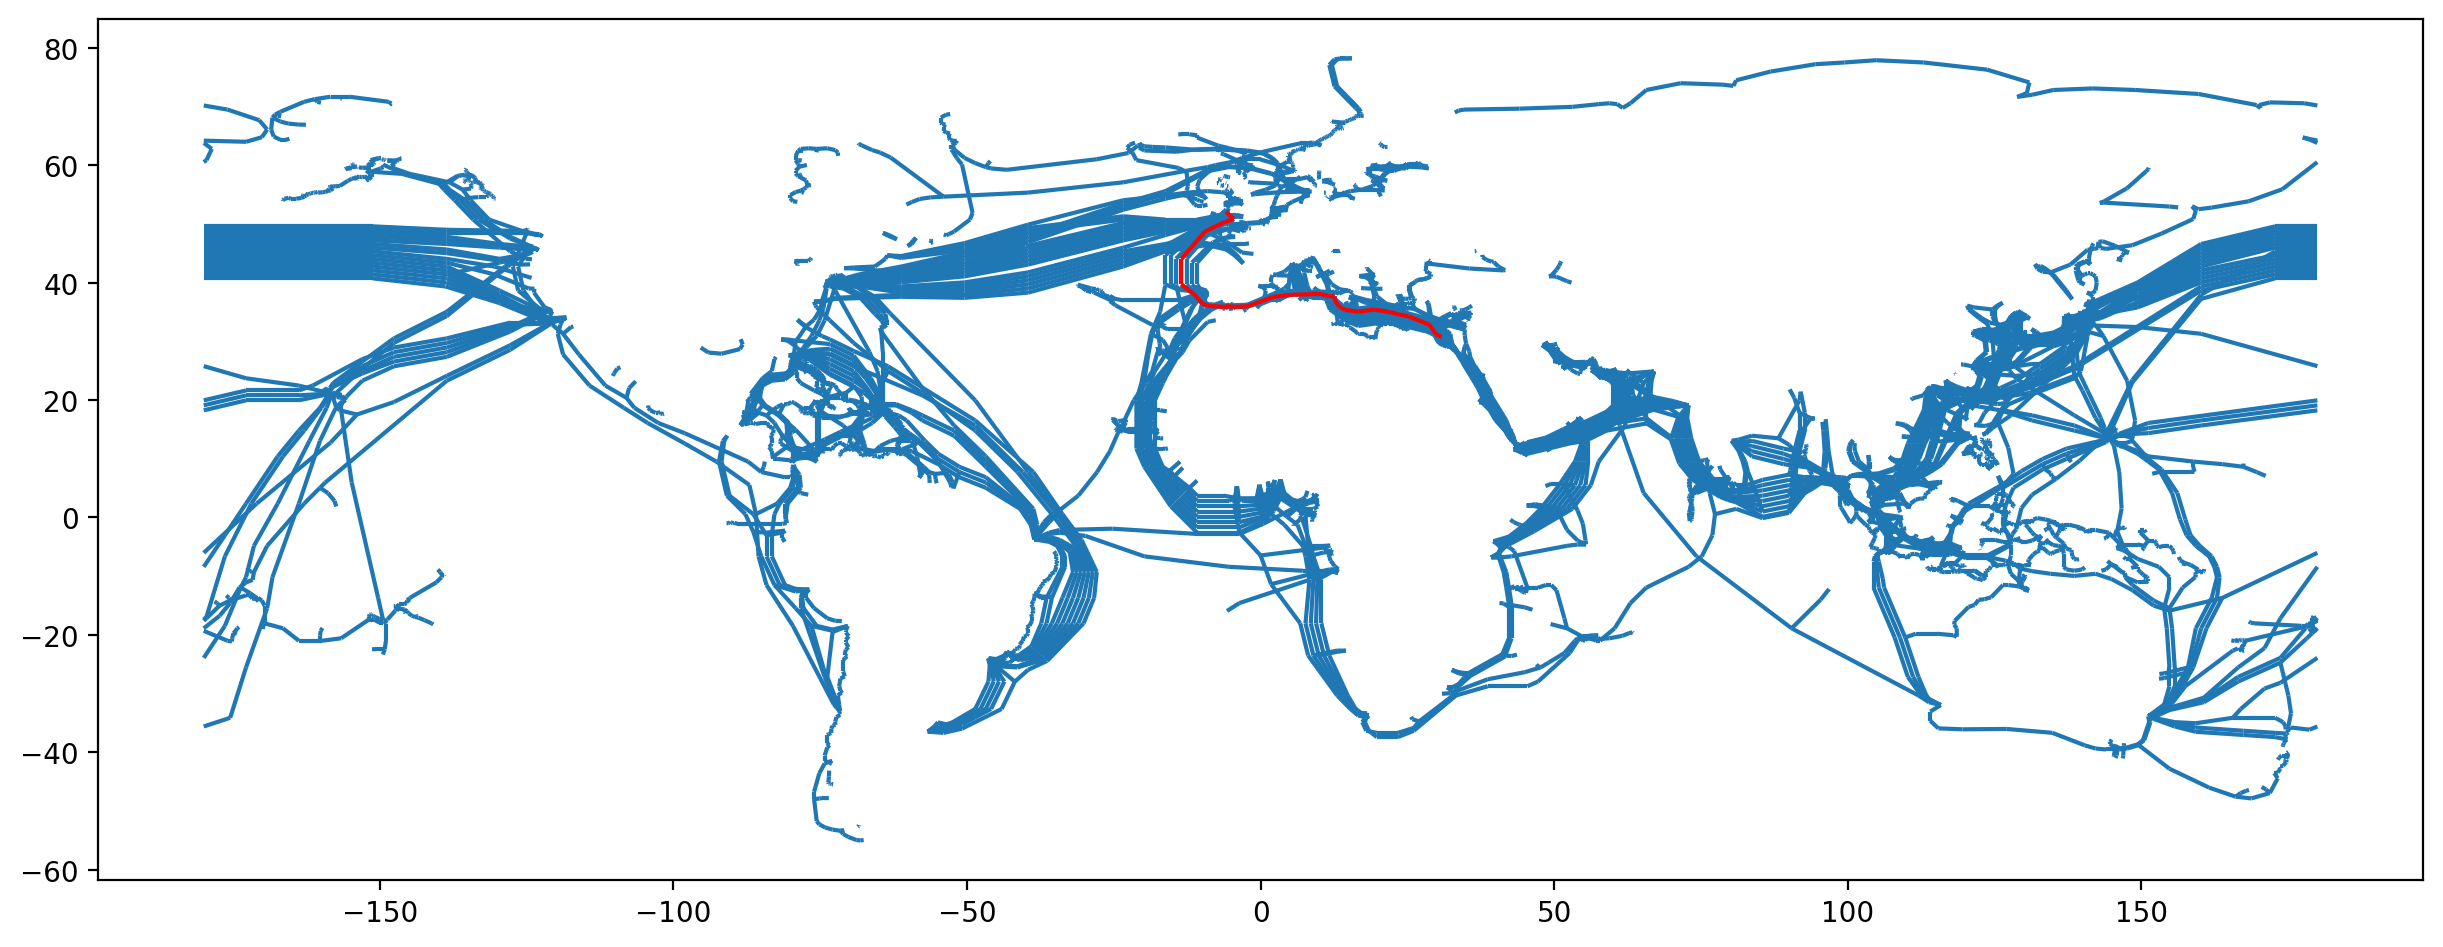

In [31]:
path = nx.shortest_path(G,6158154, 4629267, weight = 'length_from_previous')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')


In [32]:
path_road.head()

,index,lon1,lat1,cable_id,cable_length,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,line,geometry
5784,6665,30.825052,30.756490,flag-europe-asia-fea,28000.0,29.893513,31.191465,POINT (30.82505 30.75649),POINT (29.89351 31.19147),6158154.0,6108498.0,1.028090,251.382733,114.512687,LINESTRING (30.825052399183477 30.756490442252...,"LINESTRING (30.82505 30.75649, 29.89351 31.19147)"
595,673,28.800054,32.812319,seamewe-3,39000.0,29.893513,31.191465,POINT (28.80005 32.81232),POINT (29.89351 31.19147),6161237.0,6108498.0,1.955203,355.922922,214.240002,LINESTRING (28.8000538337115 32.81231878328768...,"LINESTRING (28.80005 32.81232, 29.89351 31.19147)"
596,674,25.200056,34.265678,seamewe-3,39000.0,28.800054,32.812319,POINT (25.20006 34.26568),POINT (28.80005 32.81232),5946574.0,6161237.0,3.882297,355.922922,425.399968,LINESTRING (25.20005638398345 34.2656775265242...,"LINESTRING (25.20006 34.26568, 28.80005 32.81232)"
597,675,23.400058,34.621321,seamewe-3,39000.0,25.200056,34.265678,POINT (23.40006 34.62132),POINT (25.20006 34.26568),5802138.0,5946574.0,1.834796,355.922922,201.046507,LINESTRING (23.400057658523423 34.621321285206...,"LINESTRING (23.40006 34.62132, 25.20006 34.26568)"
598,676,22.050059,34.990810,seamewe-3,39000.0,23.400058,34.621321,POINT (22.05006 34.99081),POINT (23.40006 34.62132),5704087.0,5802138.0,1.399650,355.922922,153.365610,LINESTRING (22.05005861487558 34.9908097185758...,"LINESTRING (22.05006 34.99081, 23.40006 34.62132)"


In [33]:
nx.shortest_path_length(G,6181995, 10373031, weight = 'length_from_previous')


9214.791973462634

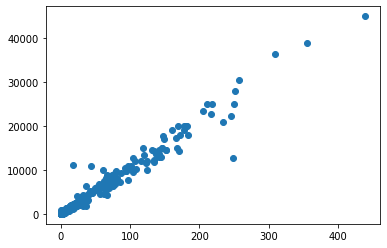

In [15]:
# path = nx.shortest_path(G,6158154, 4629267)


# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)

# path_road = getPath(path, gdf)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')


with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    temp = pd.read_sql("select sum(distance_from_previous) as cable_dis, cd.cable_id, cmlcc.merge_length as cable_length from cable_distance cd left join cable_merge_length_capacity_cost cmlcc on cd.cable_id = cmlcc.cable_id group by cd.cable_id",con=con)

plt.scatter(x= 'cable_dis', y='cable_length', data=temp)

<AxesSubplot:>

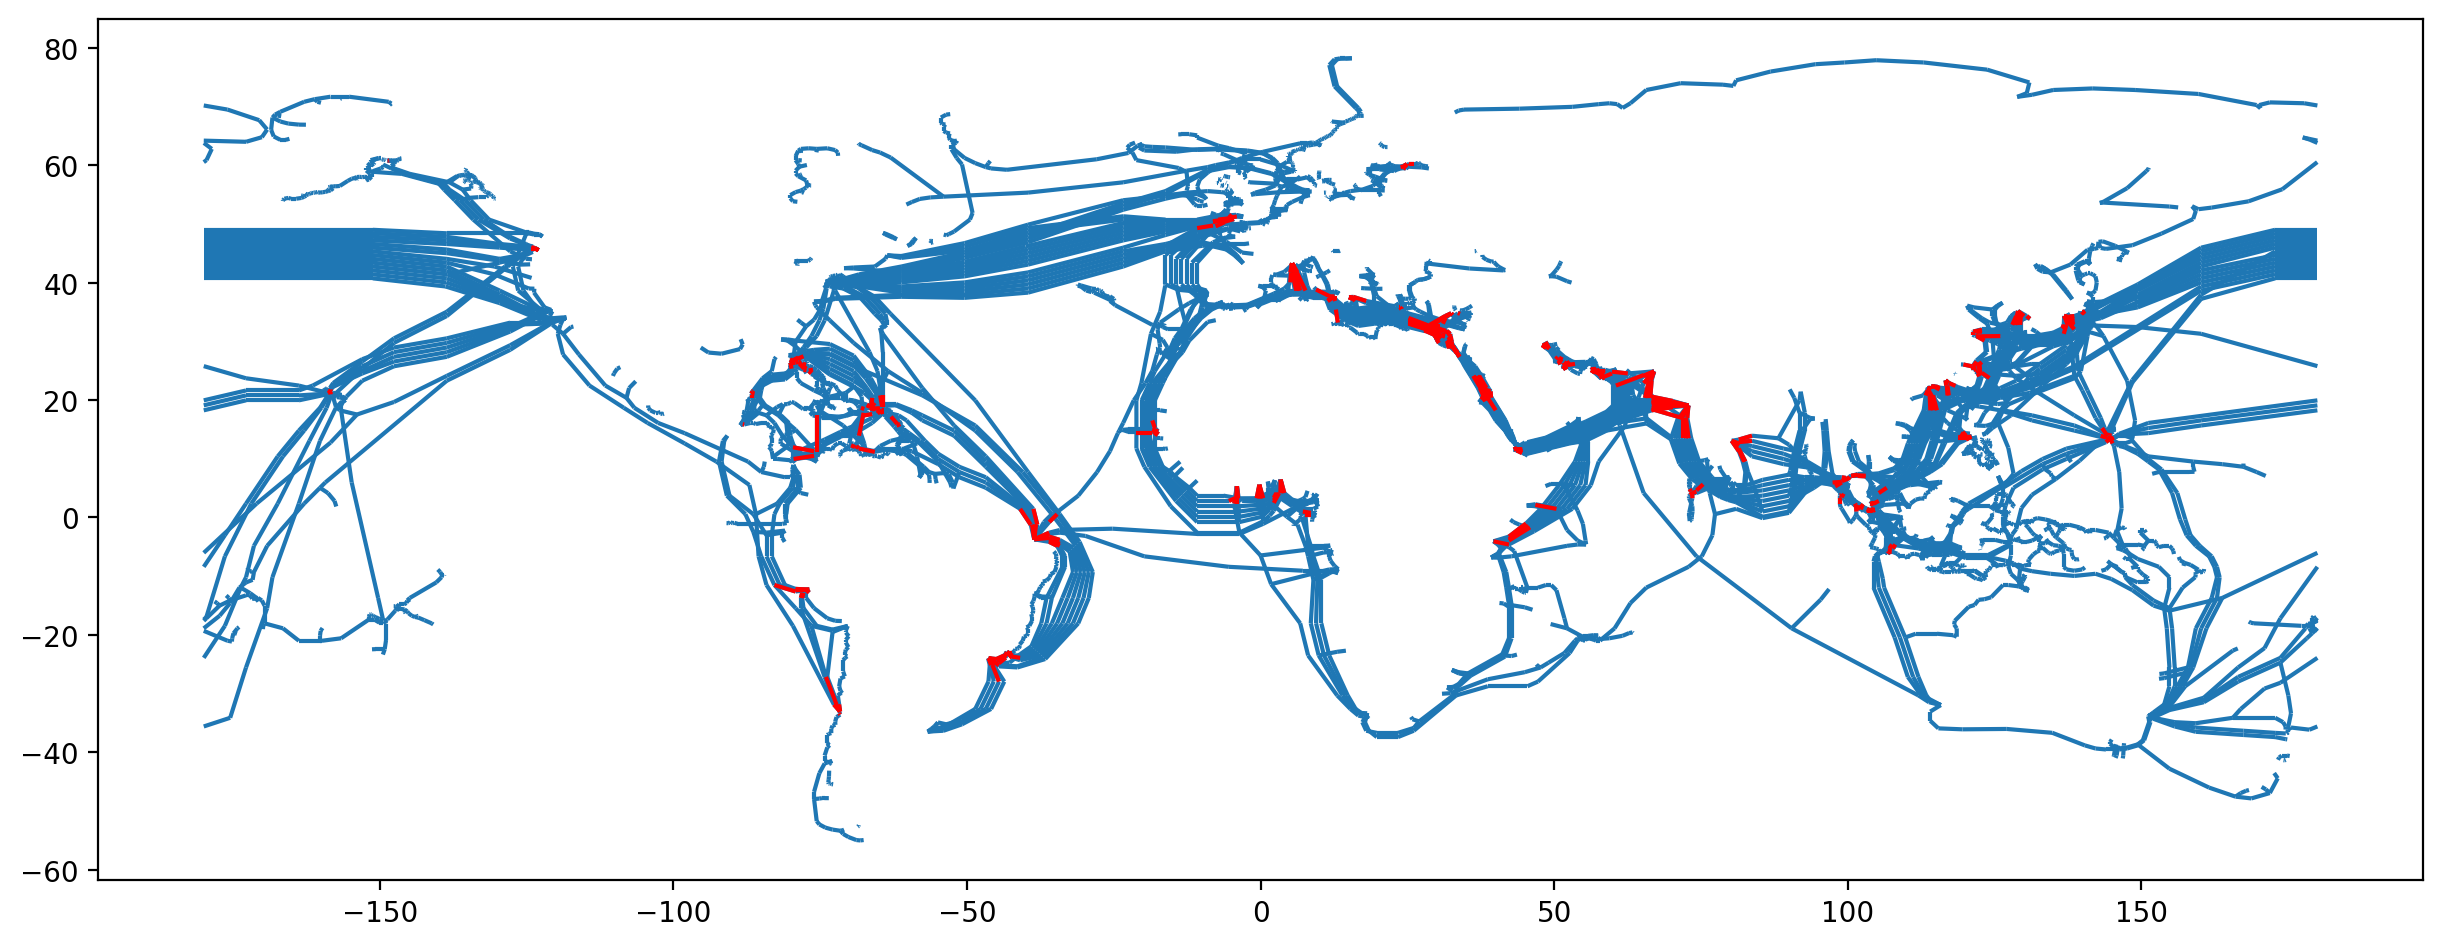

In [90]:
# https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity
temp = {}
for key, value in nx.average_neighbor_degree(G).items():
    if value >= 4:
        temp[key] = value
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf.plot(ax=ax)
gdf[gdf['fr_id'].isin(temp.keys()) ].plot(ax = ax, color='red')

In [74]:
# T = nx.minimum_spanning_tree(G, algorithm='kruskal')  # 返回包括最小生成树的图


# path_road = getPath(list (T), gdf)

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')

In [81]:
# T = nx.minimum_edge_cut(G)

NetworkXError: Input graph is not connected

In [140]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_connection = pd.read_sql("select count(*) as neighborCount, landingPoint_id, landingPoint_name, landingPoint_country, landingPoint_longitude, landingPoint_latitude from landing_points group by landingPoint_id having neighborCount >= 3",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)


landingPoint_connection_gdf = gpd.GeoDataFrame(landingPoint_connection, geometry=gpd.points_from_xy(x=landingPoint_connection['landingPoint_longitude'],y=landingPoint_connection['landingPoint_latitude']))

landingPoint_gdf = gpd.GeoDataFrame(landingPoint, geometry=gpd.points_from_xy(x=landingPoint['landingPoint_longitude'],y=landingPoint['landingPoint_latitude']))
# landingPoint_connection_gdf.plot()


# for x,y,price in zip(scatter_se.lon,scatter_se.lat,scatter_se['实用单价']):
#     hk_map.scatter(x,y,s=price/500,color='#FFEB3B',alpha=.5,ec='k',lw=.1)

In [117]:
# ax = gplt.polyplot(df=nyc_boroughs,
#                    projection=gcrs.AlbersEqualArea())
 
# # 叠加核密度图层
# ax = gplt.kdeplot(df=nyc_collision_factors,
#                   cmap='Reds',
#                   shade=True,
#                   shade_lowest=True,
#                   clip=nyc_boroughs,
#                   ax=ax)
 
# plt.savefig("图6.png", bbox_inches='tight', pad_inches=0, dpi=300)
landingPoint_connection_gdf

,neighborCount,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude,geometry
0,6,abidjan-cte-divoire,"Abidjan, Côte d'Ivoire",Côte d'Ivoire,-4.026253,5.323494,POINT (-4.02625 5.32349)
1,6,abu-talat-egypt,"Abu Talat, Egypt",Egypt,29.702495,31.071849,POINT (29.70249 31.07185)
2,6,accra-ghana,"Accra, Ghana",Ghana,-0.200914,5.558502,POINT (-0.20091 5.55850)
3,4,al-khobar-saudi-arabia,"Al Khobar, Saudi Arabia",Saudi Arabia,50.214262,26.286558,POINT (50.21426 26.28656)
4,4,al-seeb-oman,"Al Seeb, Oman",Oman,58.176107,23.684700,POINT (58.17611 23.68470)
...,...,...,...,...,...,...,...
102,5,wall-township-nj-united-states,"Wall Township, NJ, United States",United States,-74.062874,40.152887,POINT (-74.06287 40.15289)
103,6,willemstad-curaao,"Willemstad, Curaçao",Curaçao,-68.896605,12.095319,POINT (-68.89661 12.09532)
104,5,yanbu-saudi-arabia,"Yanbu, Saudi Arabia",Saudi Arabia,38.107016,24.070617,POINT (38.10702 24.07062)
105,7,yeroskipos-cyprus,"Yeroskipos, Cyprus",Cyprus,32.466688,34.766628,POINT (32.46669 34.76663)


In [143]:
world_map = folium.Map()
heatdata = landingPoint[['landingPoint_latitude','landingPoint_longitude']].values.tolist()

HeatMap(heatdata,radius=15).add_to(world_map)



neighborCount=landingPoint_connection_gdf["neighborCount"]
lon=landingPoint_connection_gdf["landingPoint_longitude"]
lat=landingPoint_connection_gdf["landingPoint_latitude"]
num=neighborCount.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(neighborCount[i]),location=[lat[i],lon[i]],color="yellow",fill=True,fill_color="red",fill_opacity=0.7).add_to(world_map)


world_map

In [134]:
type (lon)

pandas.core.series.Series